# Derivation - With pytorch

Besides numpy, we also have torch backend for the main types. This means that if you have a GPU, you can use it for the basic operations!

Please keep in mind that unfortunately, communication related operations do not happen through the GPUs, but by mpi, therefore one needs to use the numpy versions for those operations. Possible parallel suport in the future for torch directly.

#### Import general modules

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np

# Get mpi info
comm = MPI.COMM_WORLD

#### Import modules from pysemtools

In [2]:
from pysemtools.io.ppymech.neksuite import pynekread
from pysemtools.datatypes.msh import Mesh
from pysemtools.datatypes.coef import Coef
from pysemtools.datatypes.field import FieldRegistry

## Read the data and build objects

In this instance, we create connectivity for the mesh object, given that we wish to use direct stiffness summation to reduce discontinuities.

In [3]:
msh = Mesh(comm, create_connectivity=False, bckend='torch')
fld = FieldRegistry(comm, bckend='torch')
pynekread('../data/mixlay0.f00001', comm, data_dtype=np.double, msh=msh, fld=fld)
coef = Coef(msh, comm, get_area=False, bckend='torch')

2025-02-26 01:20:46,250 - Mesh - INFO - Initializing empty Mesh object.
2025-02-26 01:20:46,252 - Field - INFO - Initializing empty Field object
2025-02-26 01:20:47,072 - pynekread - INFO - Reading file: ../data/mixlay0.f00001
2025-02-26 01:20:47,076 - Mesh - INFO - Initializing Mesh object from x,y,z ndarrays.
2025-02-26 01:20:47,077 - Mesh - INFO - Initializing common attributes.
2025-02-26 01:20:47,077 - Mesh - INFO - Getting vertices
2025-02-26 01:20:47,078 - Mesh - INFO - Getting edge centers
2025-02-26 01:20:47,081 - Mesh - INFO - Facet centers not available for 2D
2025-02-26 01:20:47,226 - Mesh - INFO - Mesh object initialized.
2025-02-26 01:20:47,227 - Mesh - INFO - Mesh data is of type: torch.float64
2025-02-26 01:20:47,228 - Mesh - INFO - Elapsed time: 0.151925045s
2025-02-26 01:20:47,228 - pynekread - INFO - Reading field data
2025-02-26 01:20:47,235 - pynekread - INFO - File read
2025-02-26 01:20:47,235 - pynekread - INFO - Elapsed time: 0.163253043s
2025-02-26 01:20:47,236

### Plot the 2D velocity field

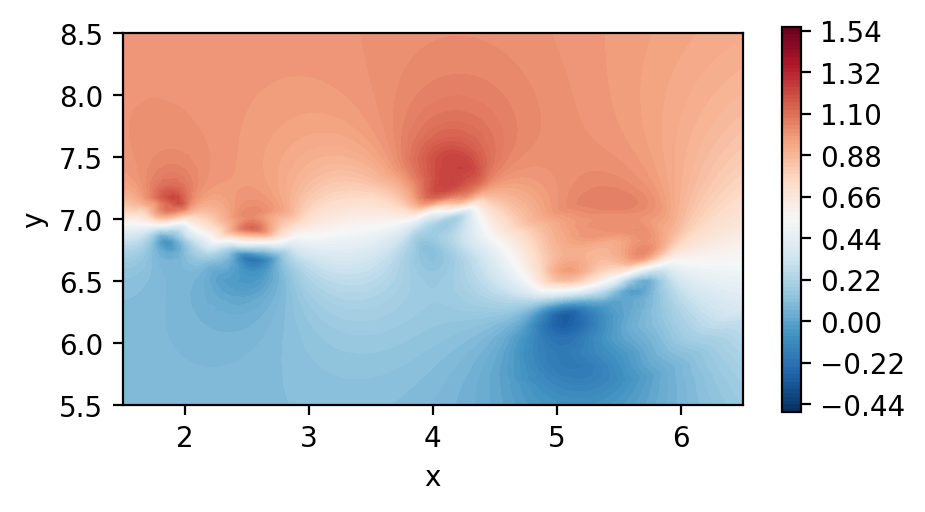

In [4]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.cpu().numpy().flatten(), msh.y.cpu().numpy().flatten() ,fld.registry["u"].cpu().numpy().flatten(), levels=100, cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

## Obtain x and y derivatives of u

Differentiation in physical space is done by using the chain rule. 

We always differentiate the the field in the reference element, i.e., we get: dudr, duds, dudt (in 3d).

To obtain the derivative in physical space, we must simply pass as inputs the components of the inverse of the jacobian matrix that will map the derivatives in the reference element to the direction we want.

For example in this case, to get the derivative in x we need to perform:

dudx = dudr * drdx + duds * dsdx

Therefore:

In [5]:
dudx = coef.dudxyz(fld.registry['u'], coef.drdx, coef.dsdx)
dudy = coef.dudxyz(fld.registry['u'], coef.drdy, coef.dsdy)

# Check the device:
print(dudx.device)
print(dudy.device)

2025-02-26 01:20:48,362 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-02-26 01:20:48,367 - Coef - INFO - done
2025-02-26 01:20:48,368 - Coef - INFO - Elapsed time: 0.004295227999999929s
2025-02-26 01:20:48,370 - Coef - INFO - Calculating the derivative with respect to physical coordinates
2025-02-26 01:20:48,371 - Coef - INFO - done
2025-02-26 01:20:48,372 - Coef - INFO - Elapsed time: 0.0017059100000000882s
cuda:0
cuda:0


### Plot the derivatives

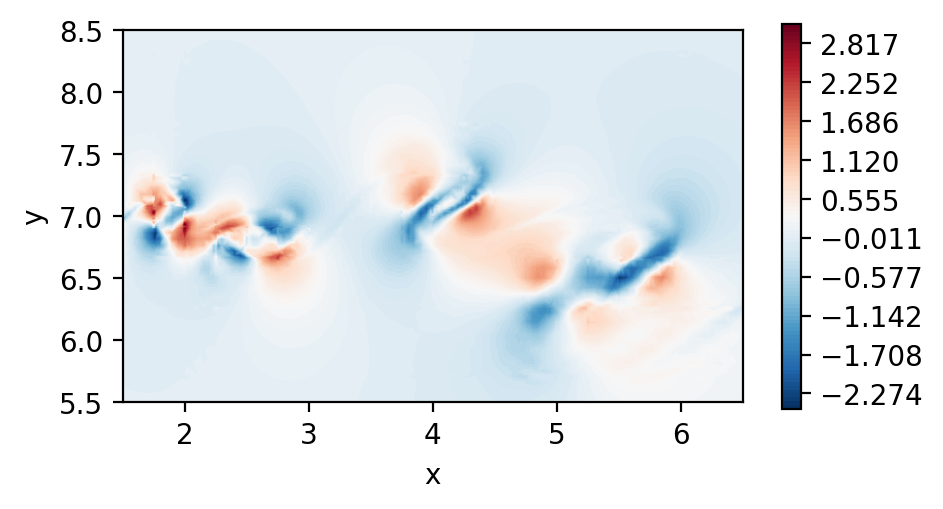

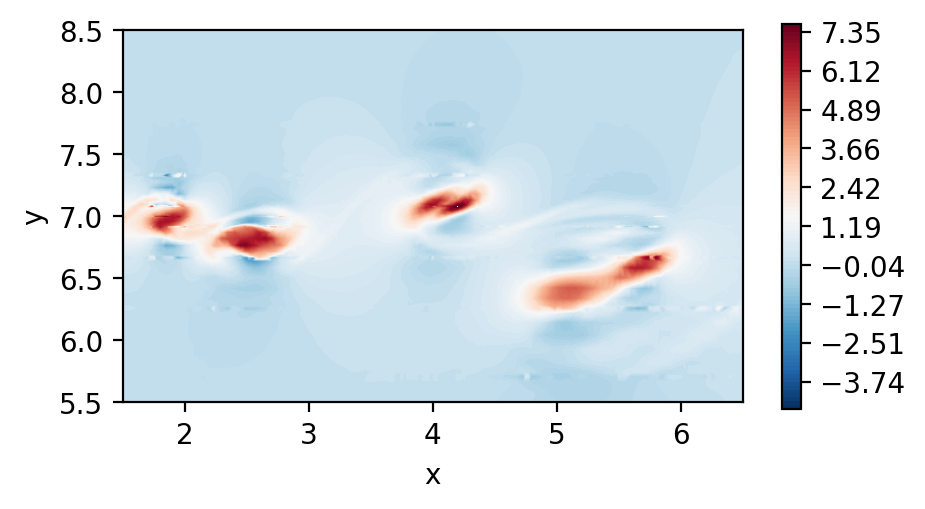

In [6]:
fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.cpu().numpy().flatten(), msh.y.cpu().numpy().flatten() ,dudx.cpu().numpy().flatten(), levels=np.linspace(-2.5,3.1,100), cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

fig, ax = plt.subplots(figsize=(5, 2.5), dpi = 200)
c = ax.tricontourf(msh.x.cpu().numpy().flatten(), msh.y.cpu().numpy().flatten() ,dudy.cpu().numpy().flatten(), levels=np.linspace(-4.6,7.6,100), cmap="RdBu_r")
fig.colorbar(c)
ax.set_aspect('equal')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_xlim([1.5,6.5])
ax.set_ylim([5.5,8.5])
plt.show()

## Check the area of the domain (Integration)

The domain is x=20, y=14 so 280 is the right value.

In [7]:
# Check the device of the mass matrix:
print(f'Device of mass matrix is {coef.B.device}')

# Compute the area of the domain:
area = coef.glsum(coef.B, comm, dtype=np.double)
print(f'Area of the domain: {area}')

Device of mass matrix is cuda:0
Area of the domain: 280.00000000000034
